# ARIMA PREDICTION

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
df = pd.read_csv(os.getcwd()+"/pre_processing/dataset_traite.csv", sep=',', parse_dates=["DateTime"])


In [ ]:
df

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...
2075254,2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,2010-11-26 21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0


In [ ]:
#df = df.set_index('DateTime')

data = df.groupby(pd.Grouper(key='DateTime',freq='W')).mean()

data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-17,2.505248,0.142118,239.258088,10.664161,1.107298,2.577887,9.949346
2006-12-24,1.734059,0.116708,241.369629,7.341434,1.110342,2.118412,7.684516
2006-12-31,1.958204,0.144105,241.910007,8.237327,1.412623,2.245099,6.671619
2007-01-07,1.152164,0.109719,238.848573,4.885499,1.068861,0.860149,6.093299
2007-01-14,1.421880,0.146196,239.000173,6.065497,2.435584,1.493608,6.924711


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


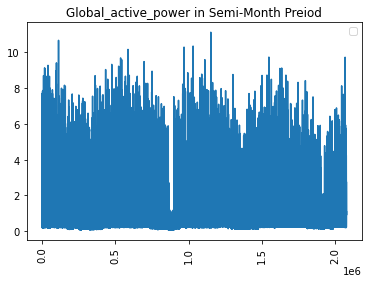

In [ ]:
plt.plot(df['Global_active_power'],linestyle='solid')
plt.xticks(rotation=90)
plt.title ('Global_active_power in Semi-Month Period')
plt.legend()
plt.show()

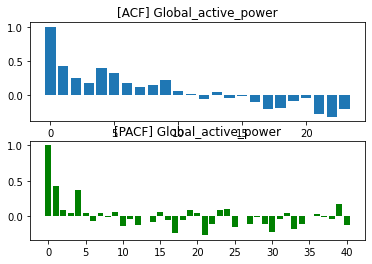

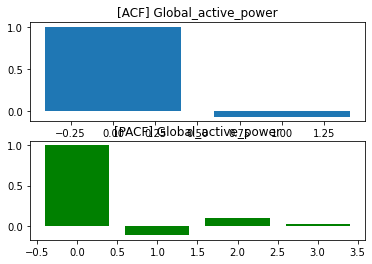

In [ ]:
skip_items = list()
include_items = ['Global_active_power']#,'Global_reactive_power','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3','other_power_consumption']
for i in data:
    if i not in include_items:
        continue
    
    series = data[i]
    
    test_series = series - series[0]
    if test_series.sum() == 0:
        continue
        
    ACF_Trend = acf(series)[:]
    PACF_Trend = pacf(series,40)[:]

    ACF_Trend_12 = acf(series)[::12]
    PACF_Trend_12 = pacf(series,40)[::12]
    
    
    fig, ax = plt.subplots(2)
    ax[0].set_title('[ACF] ' + str(i))
    ax[0].bar(range(ACF_Trend.size),ACF_Trend)
    #ax[0].bar(range(PACF_Trend.size),PACF_Trend,color = 'green')
    ax[1].set_title('[PACF] '+ str(i))
    ax[1].bar(range(PACF_Trend.size),PACF_Trend,color = 'green')
    #ax[2].set_title('Figure '+ str(i))
    #ax[2].plot(range(series.size),series)

    fig, ax = plt.subplots(2)
    ax[0].set_title('[ACF] ' + str(i))
    ax[0].bar(range(ACF_Trend_12.size),ACF_Trend_12)
    #ax[0].bar(range(PACF_Trend.size),PACF_Trend,color = 'green')
    ax[1].set_title('[PACF] '+ str(i))
    ax[1].bar(range(PACF_Trend_12.size),PACF_Trend_12,color = 'green')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.59723D-02    |proj g|=  2.03651D-01

At iterate    5    f=  2.50522D-02    |proj g|=  2.86749D-02

At iterate   10    f=  2.01817D-02    |proj g|=  3.84745D-01

At iterate   15    f=  3.19160D-03    |proj g|=  8.41685D-02

At iterate   20    f=  1.69810D-03    |proj g|=  4.93061D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     30      1     0     0   1.162D-05   1.694D-03
  F =   1.6939797817957210E-003

CONVERG

 This problem is unconstrained.


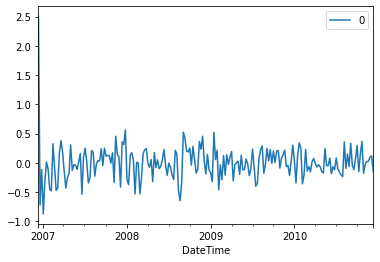

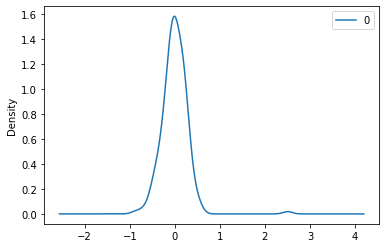

In [ ]:
X = data['Global_active_power']
#Cut_size = int(len(X) * 0.1)
#withdraw, series = X[0:Cut_size], X[Cut_size:len(X)]
# fit model
#model = ARIMA(series, order=(0,0,0))
#model = ARIMA(series, order=(2,0,2))
#model = SARIMAX(series,  order=(2,0,3),seasonal_order = (2,0,3,12))
model = SARIMAX(X, order=(1,0,1))
model_fit = model.fit()
# summary of fit model

print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44200D-01    |proj g|=  3.07602D-01

At iterate    5    f=  1.29422D-01    |proj g|=  1.51178D-02

At iterate   10    f=  1.26254D-01    |proj g|=  3.07138D-01

At iterate   15    f=  1.00988D-01    |proj g|=  6.78069D-02

At iterate   20    f=  9.85093D-02    |proj g|=  5.21260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     28      1     0     0   6.077D-06   9.850D-02
  F =   9.8501699177954621E-002

CONVERG

 This problem is unconstrained.


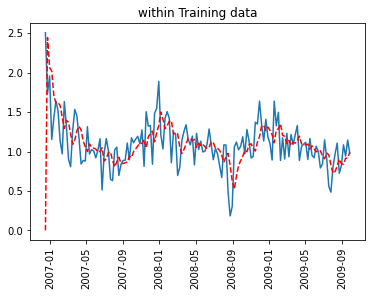

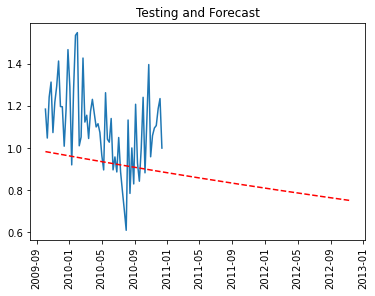

RMSE in Testing Data: 0.24460108751863938


In [ ]:
# split into train and test sets
X = data['Global_active_power']#.values
size = int(len(X) * 0.7)
Test_size = len(X) - size
train, test = X[0:size], X[size:len(X)]

#model = ARIMA(history, order=(1,0,0))
model = SARIMAX(train, order=(1,0,1))
model_fit = model.fit()
in_sample_forecast =model_fit.predict() #cut first value since it start value is 0
out_sample_forecast = model_fit.get_forecast(Test_size+100, alpha = 0.4) #forecast on 100 period after

#in Data Plot
plt.plot(X[:size])
plt.plot(in_sample_forecast, color='red',linestyle='dashed')
plt.xticks(rotation='vertical')
plt.title('within Training data')
plt.show()

#Forecast Plot
plt.plot(X[size:len(X)])
plt.plot(out_sample_forecast.predicted_mean, color='red',linestyle='dashed')
#plt.plot(out_sample_forecast.conf_int()['lower Global_active_power'], color='green',linestyle='dashed')
#plt.plot(out_sample_forecast.conf_int()['upper Global_active_power'], color='green',linestyle='dashed')
plt.xticks(rotation='vertical')
plt.title('Testing and Forecast')
plt.show()

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
MSE = mean_squared_error(y_true = np.array(X[size:len(X)]), y_pred = out_sample_forecast.predicted_mean[:Test_size])
print('RMSE in Testing Data:' , MSE**(0.5))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.81631D+00    |proj g|=  4.36941D+01


/home/ubuntu/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  6.86613D-01    |proj g|=  2.66427D-01

At iterate   10    f=  6.69321D-01    |proj g|=  2.74267D-02

At iterate   15    f=  6.00794D-01    |proj g|=  7.78867D-02

At iterate   20    f=  5.94409D-01    |proj g|=  2.55207D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     30      1     0     0   3.833D-06   5.944D-01
  F =  0.59440676814163418     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


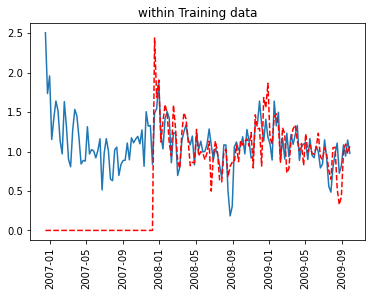

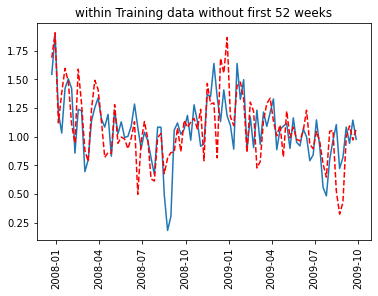

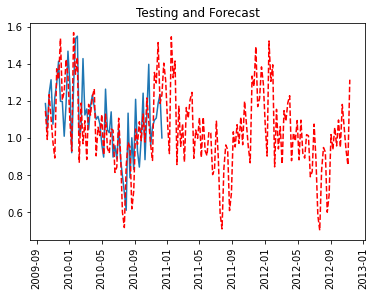

RMSE in Testing Data: 0.17681589003814688


In [ ]:
#Only Seasonly parameter
# split into train and test sets
X = data['Global_active_power']#.values
size = int(len(X) * 0.7)
Test_size = len(X) - size
train, test = X[0:size], X[size:len(X)]

#model = ARIMA(history, order=(1,0,0))
model = SARIMAX(train, order=(0,0,0),seasonal_order = (1,0,1,52))
model_fit = model.fit()
in_sample_forecast =model_fit.predict() #cut first value since it start value is 0
out_sample_forecast = model_fit.get_forecast(Test_size+100, alpha = 0.4) #forecast on 100 period after

#in Data Plot
plt.plot(X[:size])
plt.plot(in_sample_forecast, color='red',linestyle='dashed')
plt.xticks(rotation='vertical')
plt.title('within Training data')
plt.show()

#in Data Plot
plt.plot(X[53:size])
plt.plot(in_sample_forecast[53:], color='red',linestyle='dashed')
plt.xticks(rotation='vertical')
plt.title('within Training data without first 52 weeks')
plt.show()

#Forecast Plot
plt.plot(X[size:len(X)])
plt.plot(out_sample_forecast.predicted_mean, color='red',linestyle='dashed')
#plt.plot(out_sample_forecast.conf_int()['lower Global_active_power'], color='green',linestyle='dashed')
#plt.plot(out_sample_forecast.conf_int()['upper Global_active_power'], color='green',linestyle='dashed')
plt.xticks(rotation='vertical')
plt.title('Testing and Forecast')
plt.show()



MSE = mean_squared_error(y_true = np.array(X[size:len(X)]), y_pred = out_sample_forecast.predicted_mean[:Test_size])
print('RMSE in Testing Data:' , MSE**(0.5))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   DateTime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


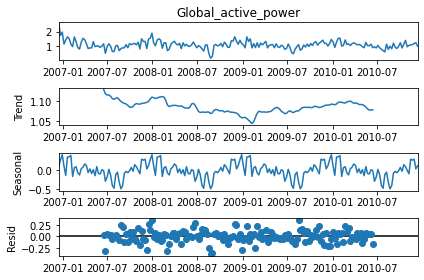

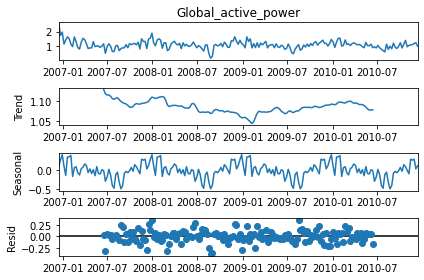

In [175]:
df2 = pd.read_csv(os.getcwd()+"/pre_processing/dataset_traite.csv", sep=',', parse_dates=["DateTime"])
df2 = df2.set_index('DateTime')
data2 = df2.resample('W').mean()
data2.fillna(data2.mean(), inplace=True)
results = seasonal_decompose(data2["Global_active_power"])
results.plot()

In [ ]:
data2 = df2.resample('h').mean()
# data2 = df2.copy()

In [ ]:
data2 = data2.loc[(data2.index >= '2007-03-01') & (data2.index <= '2007-04-01')]

In [ ]:
data2.isna().sum().sum()

0

In [ ]:
data2.fillna(data2.mean(), inplace=True)

In [ ]:
results = seasonal_decompose(data2["Global_active_power"])

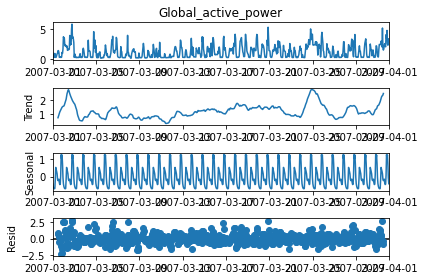

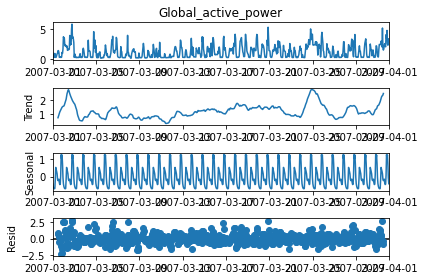

In [ ]:
results.plot()

In [ ]:
result_seas = pd.DataFrame(results.seasonal)

<AxesSubplot:xlabel='DateTime'>

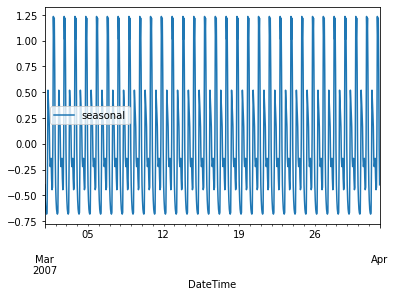

In [ ]:
result_seas.plot()